In [6]:
# coding: utf-8
# *First compiled on May 5, 2017. Updated August 14, 2018.*
# # Clustering 3k PBMCs following a Seurat Tutorial
#
# This started out with a demonstration that Scanpy would allow to reproduce most of Seurat's
# ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) clustering tutorial as described on
# http://satijalab.org/seurat/pbmc3k_tutorial.html (July 26, 2017), which we gratefully acknowledge.
# In the meanwhile, we have added and removed several pieces.
#
# The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics
# ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
# from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

from pathlib import Path

import numpy as np
import pytest
import os

from matplotlib import pyplot
import scanpy as sc
from matplotlib.testing.compare import compare_images


def make_comparer(path_expected: Path, path_actual: Path, *, tol: int):
    def save_and_compare(basename, tolerance=None):
        path_actual.mkdir(parents=True, exist_ok=True)
        out_path = path_actual / f'{basename}.png'
        pyplot.savefig(out_path, dpi=40)
        pyplot.close()
        if tolerance is None:
            tolerance = tol
        res = compare_images(
            str(path_expected / f'{basename}.png'), str(out_path), tolerance
        )
        assert res is None, res

    return save_and_compare


def image_comparer():
    return make_comparer


HERE: Path = Path('.')
ROOT = HERE / 'pbmc3k_images'
FIGS = HERE / 'figures'

from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

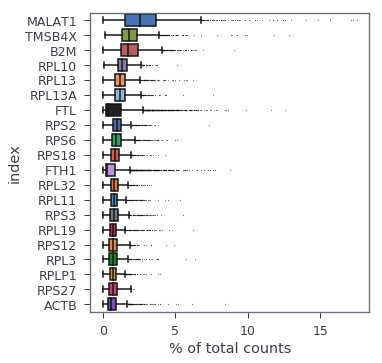

In [11]:
save_and_compare_images = image_comparer()

adata = sc.read('./data/pbmc3k_raw.h5ad',
                backup_url='http://falexwolf.de/data/pbmc3k_raw.h5ad')

# Preprocessing

sc.pl.highest_expr_genes(adata, n_top=20, show=False)
#save_and_compare_images('highest_expr_genes')

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

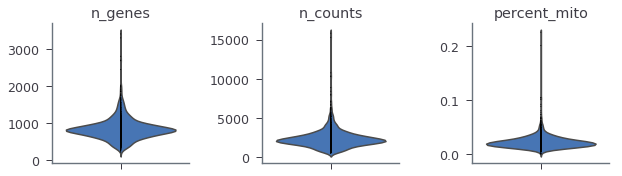

In [12]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse to transform to a dense array after summing
adata.obs['percent_mito'] = (np.sum(adata[:, mito_genes].X, axis=1).A1 /
                             np.sum(adata.X, axis=1).A1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(
    adata,
    ['n_genes', 'n_counts', 'percent_mito'],
    jitter=False,
    multi_panel=True,
    show=False,
)
#save_and_compare_images('violin')

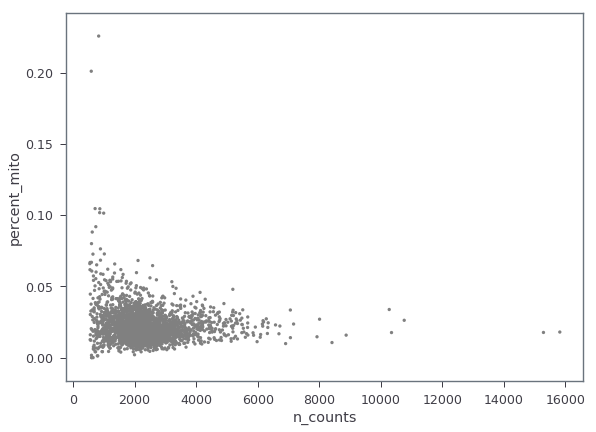

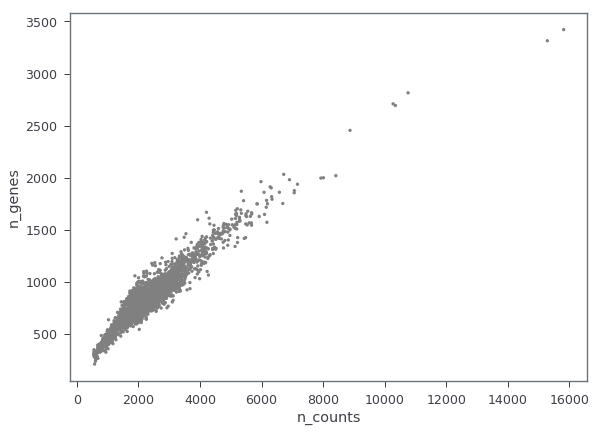

In [13]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito', show=False)
#save_and_compare_images('scatter_1')
sc.pl.scatter(adata, x='n_counts', y='n_genes', show=False)
#save_and_compare_images('scatter_2')


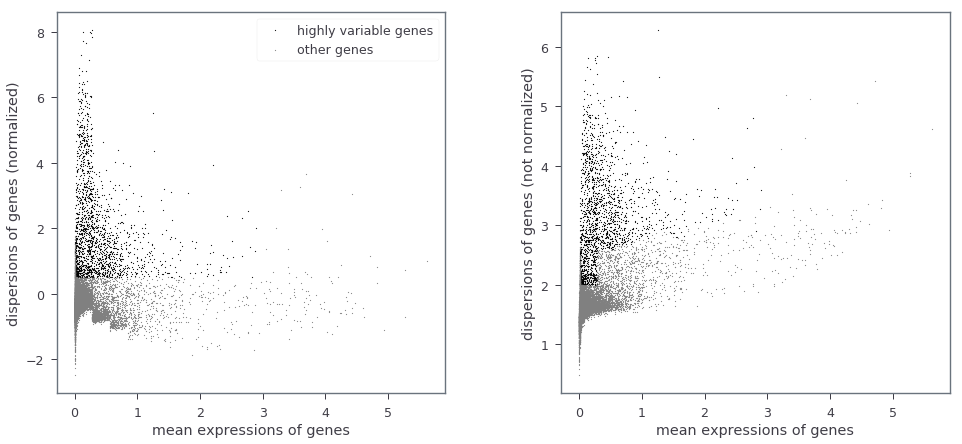

In [14]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

adata.raw = sc.pp.log1p(adata, copy=True)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5,
)
sc.pl.filter_genes_dispersion(filter_result, show=False)
#save_and_compare_images('filter_genes_dispersion')


/projects/ps-epigen/software/miniconda3/envs/scanpy/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


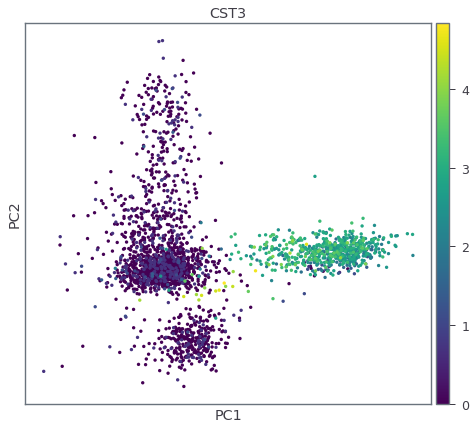

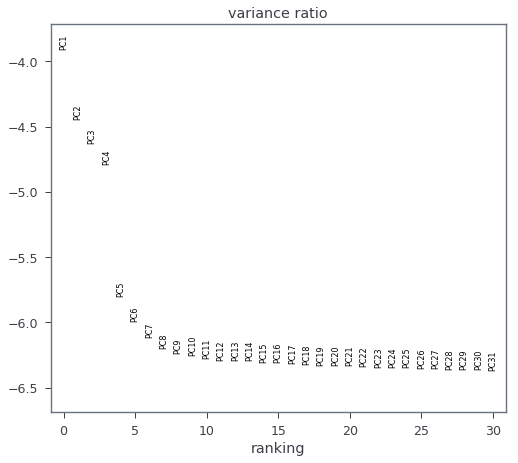

In [15]:

adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

# PCA

sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3', show=False)
#save_and_compare_images('pca')

sc.pl.pca_variance_ratio(adata, log=True, show=False)
#save_and_compare_images('pca_variance_ratio')


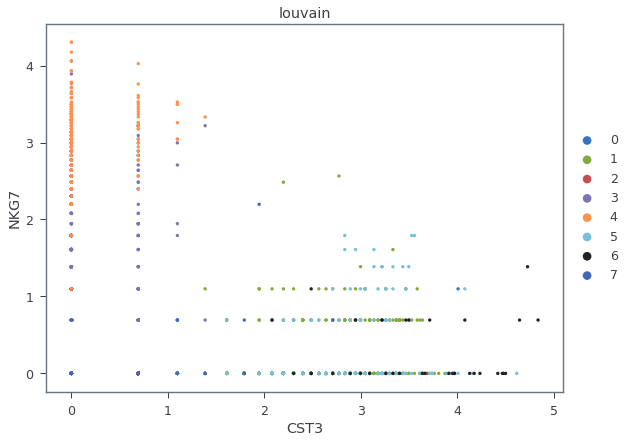

In [16]:
# UMAP

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata)  # umaps lead to slight variations

# sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False, show=False)
# save_and_compare_images('umap_1')

# Clustering the graph

sc.tl.louvain(adata)
# sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'], show=False)
# save_and_compare_images('umap_2')
sc.pl.scatter(adata, 'CST3', 'NKG7', color='louvain', show=False)
#save_and_compare_images('scatter_3')


/projects/ps-epigen/software/miniconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/projects/ps-epigen/software/miniconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


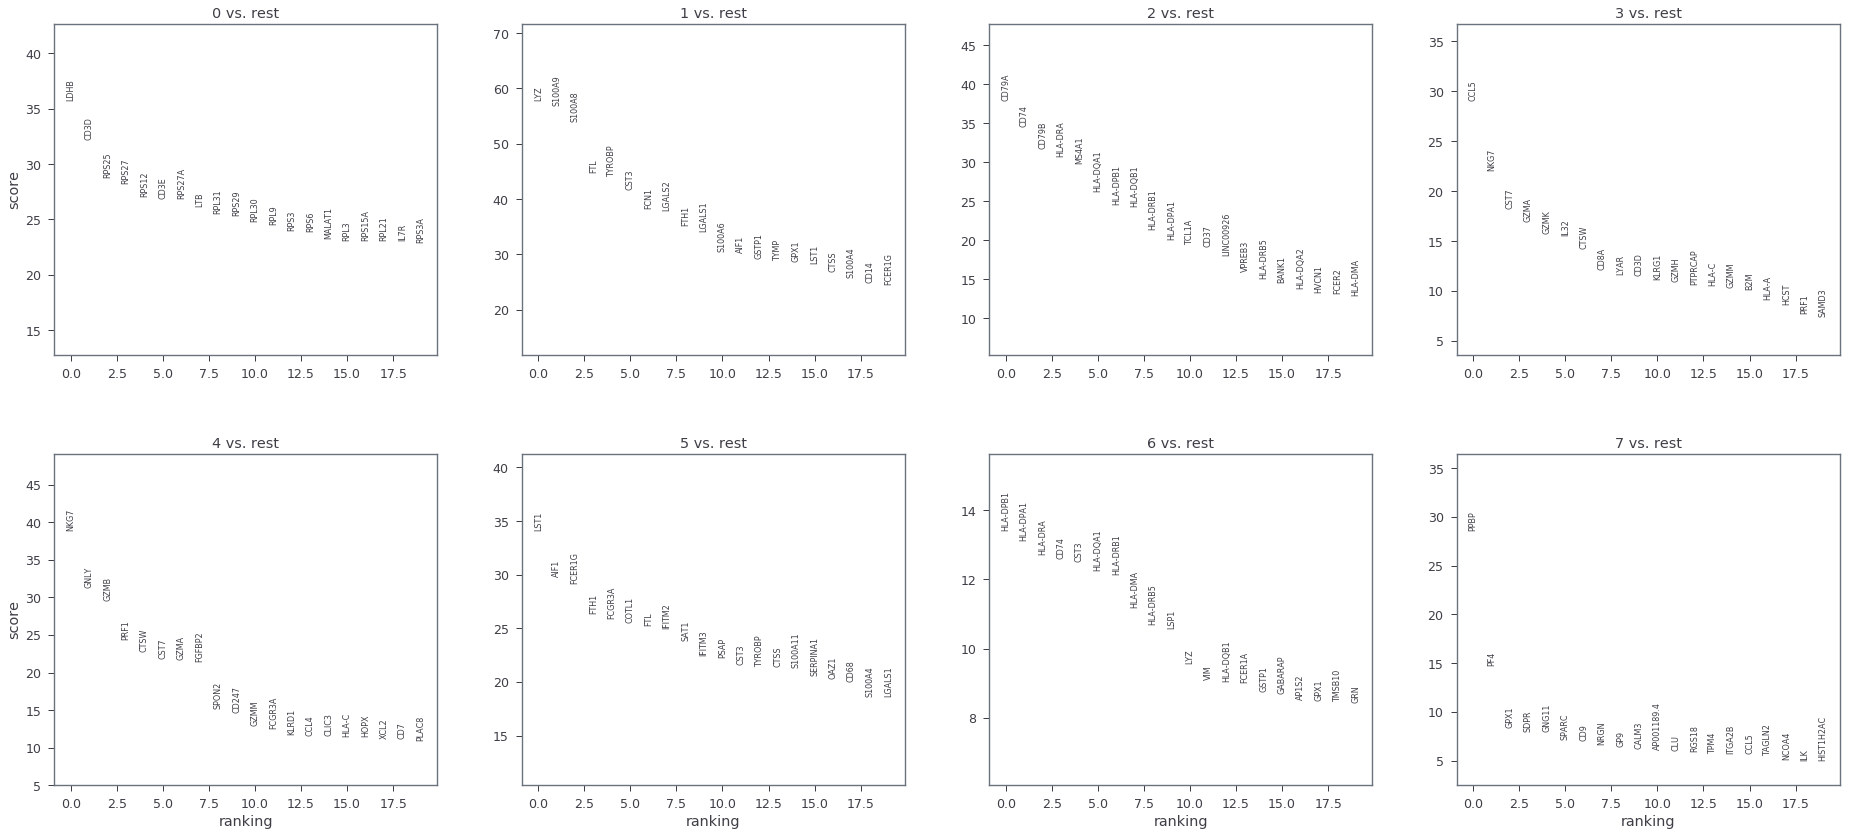

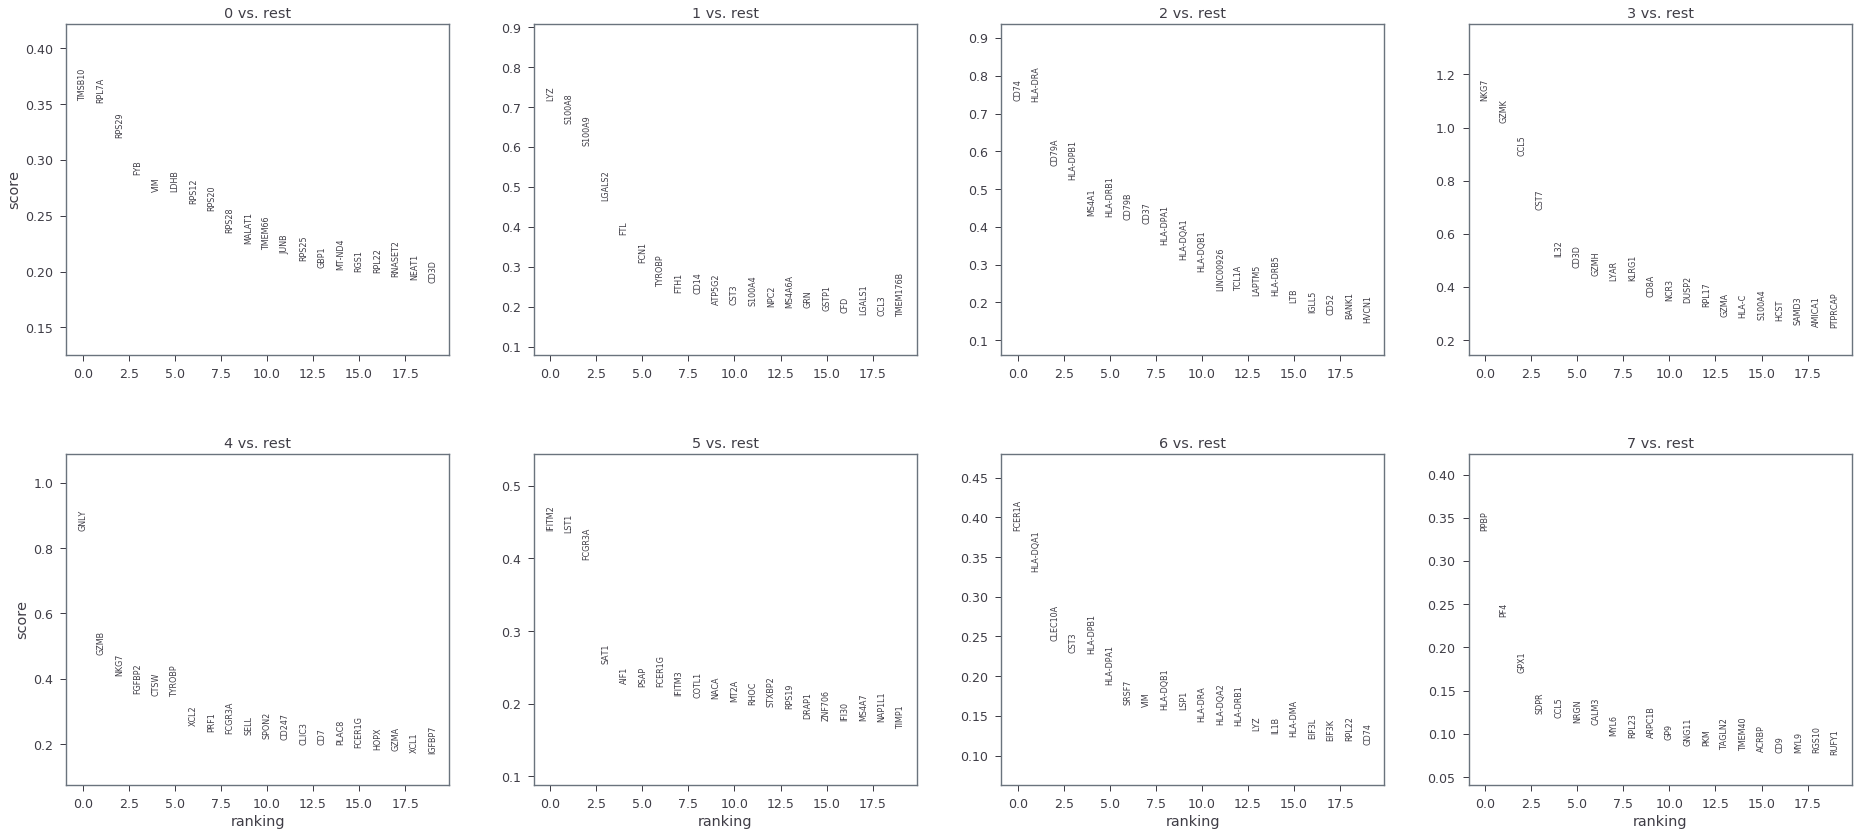

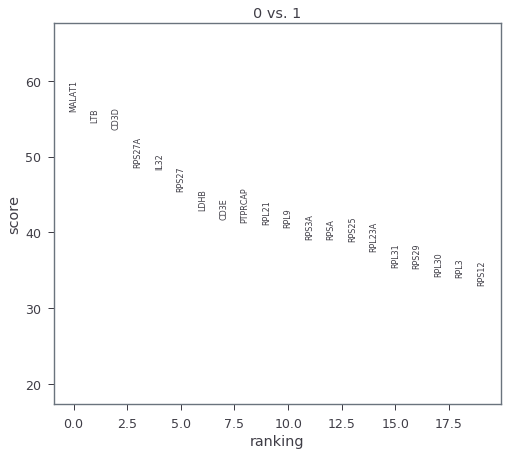

In [17]:
# Finding marker genes

sc.tl.rank_genes_groups(adata, 'louvain')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, show=False)
#save_and_compare_images('rank_genes_groups_1')

sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, show=False)
#save_and_compare_images('rank_genes_groups_2')

sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1')
sc.pl.rank_genes_groups(adata, groups='0', n_genes=20, show=False)
#save_and_compare_images('rank_genes_groups_3')

Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.


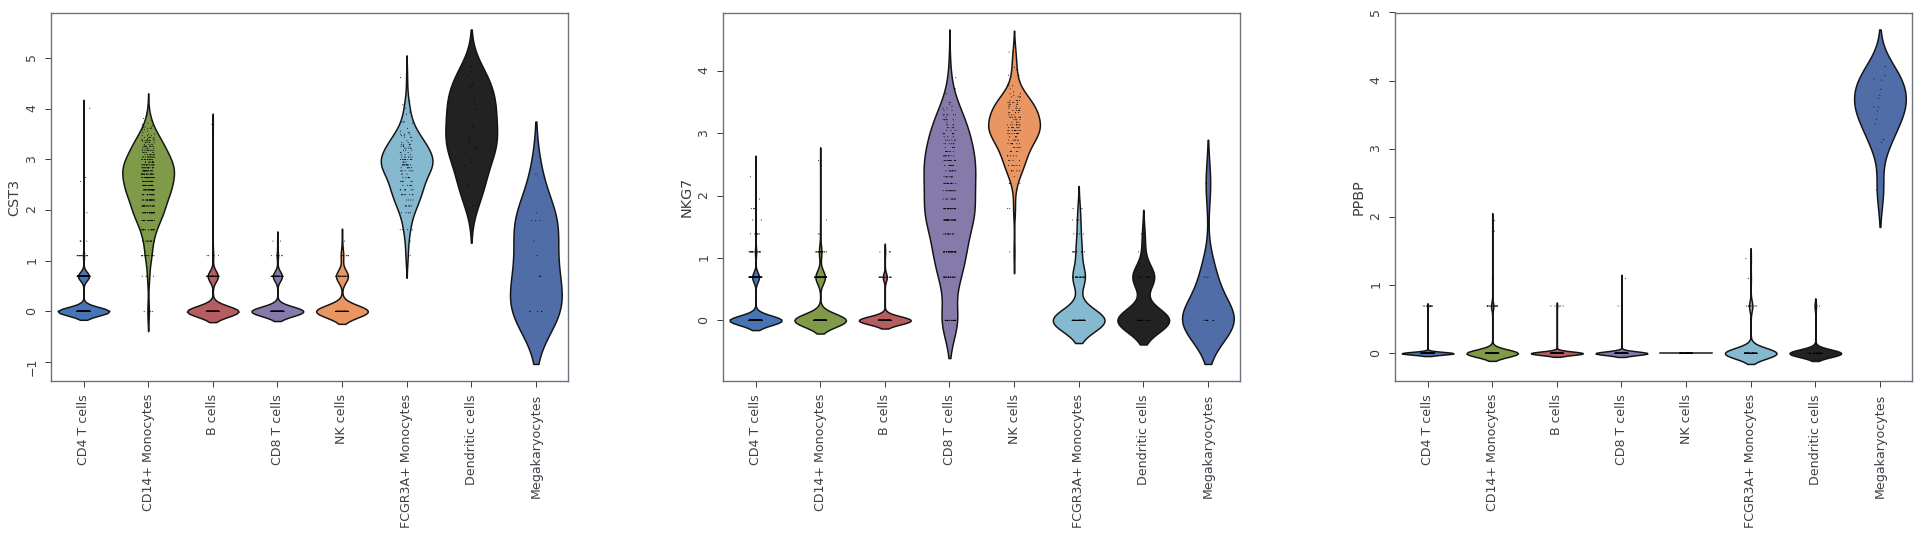

In [18]:
# gives a strange error, probably due to jitter or something
# sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)
# save_and_compare_images('rank_genes_groups_4')

new_cluster_names = [
    'CD4 T cells', 'CD14+ Monocytes',
    'B cells', 'CD8 T cells',
    'NK cells', 'FCGR3A+ Monocytes',
    'Dendritic cells', 'Megakaryocytes',
]
adata.rename_categories('louvain', new_cluster_names)

# sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, show=False)
# save_and_compare_images('umap_3')

sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain', rotation=90, show=False)
#save_and_compare_images('violin_2')